# Test 10-5-3 Network
Purpose: To test the new implementation of Predictive Coding. This notebook also demonstrates the effects of dynamic decay rates. As a quantity evolves (value nodes, or connection weights), we reduce the decay rate. This notebook shows that the generated samples converge to the class prototypes.

In [475]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [63]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 2950
torch.manual_seed(seed)
np.random.seed(seed)
B = torch.eye(n_classes)
X = 3.*(torch.rand((sensory_dim, n_classes)) - 0.5)
A = X.T
print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[ 0.3232, -0.9563,  0.5234,  1.4845, -0.3955,  0.9563, -0.8818, -1.4115,
          1.3157,  0.8915],
        [ 1.2468,  0.5938,  0.8025, -1.0985, -1.3189, -0.9960,  0.8459, -0.2334,
          0.5250,  1.1660],
        [-0.8239, -1.1012,  0.0545,  0.2905, -0.4973,  1.3367, -1.4346,  0.9836,
         -0.9238, -0.5371]])
Target vectors
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [526]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,idx[0]], X[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [527]:
blah = SimpleDataset(A, B, n=300, noise=0.1)

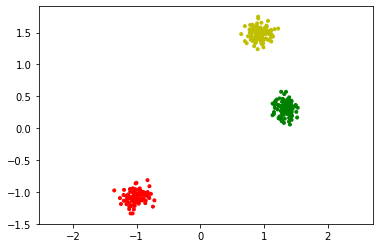

In [528]:
blah.Plot(idx=(5,3))

In [529]:
blah.ClassMean()

tensor([[ 0.3223, -0.9652,  0.5321,  1.4785, -0.3967,  0.9434, -0.8914, -1.4121,
          1.3196,  0.8917],
        [ 1.2417,  0.5834,  0.8037, -1.0852, -1.3299, -0.9992,  0.8389, -0.2193,
          0.5342,  1.1640],
        [-0.8127, -1.0946,  0.0548,  0.3026, -0.4985,  1.3369, -1.4174,  0.9803,
         -0.9106, -0.5259]])

# Create Network

In [503]:
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=10))  # input
net.AddLayer(PCLayer.PCLayer(n=5))   # e1
net.AddLayer(PCLayer.PCLayer(n=5))   # v1
net.AddLayer(PCLayer.PCLayer(n=3))   # e2
net.AddLayer(PCLayer.PCLayer(n=3))   # v2

af = 'tanh'
sym = True
net.Connect(v_idx=0, e_idx=1, type='general', sym=sym, act_text='identity')
net.Connect(v_idx=2, e_idx=1, type='1to1')
net.Connect(v_idx=2, e_idx=3, type='general', sym=sym, act_text=af)
net.Connect(v_idx=4, e_idx=3, type='1to1')

net.SetTau(0.05)

# Training

In [530]:
simple_ds = SimpleDataset(A, B, n=200, noise=0.2)
dl = DataLoader(simple_ds, batch_size=25, shuffle=True)
hold = 4.

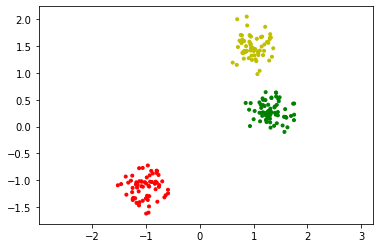

In [531]:
simple_ds.Plot(idx=(5,3))

In [504]:
net.SetDynamicWeightDecay(0.05, 0.5)
net.Learn(dl, T=4., epochs=2)

Epoch: 0 weight decay = 0.05
Epoch: 1 weight decay = 0.025


# Classification

In [505]:
net.Reset(random=1.)
net.lyr[-1].Probe(True)
net.Predict(A, T=2.)

tensor([[ 0.9567,  0.0240,  0.0353],
        [-0.0178,  0.9917,  0.0013],
        [-0.0197,  0.0044,  0.9944]])

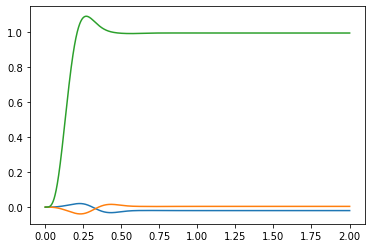

In [506]:
net.lyr[-1].Plot(net.t_history, idx=2);

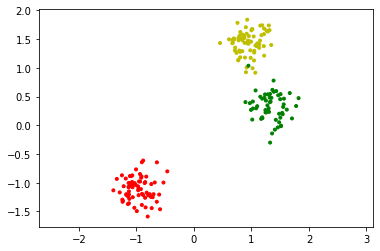

In [507]:
sidx = (5,3)
simple_ds.Plot(labels=net.Predict(simple_ds.Inputs(), T=2.), idx=sidx)

# Generation

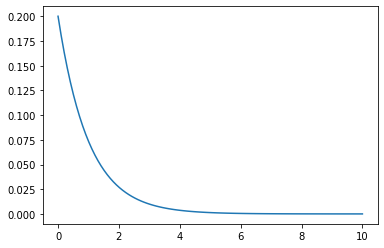

In [508]:
def lambda_x(t):
    return 0.2*np.exp(-t/1.)
tt = torch.linspace(0, 10, 100)
plt.plot(tt, lambda_x(tt));

In [532]:
net.Reset(random=1.)
net.SetActivityDecay(lambda_x)
#net.SetActivityDecay((lambda t: 0.1 if t<2 else 0.))
net.lyr[0].Probe(True)
z = net.Generate(simple_ds.Targets(), T=20.)

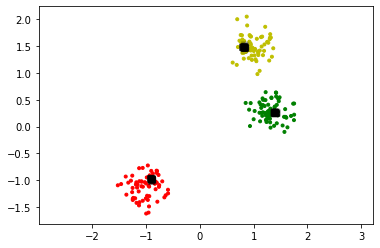

In [533]:
simple_ds.Plot(idx=sidx)
plt.plot(np.array(z[:,sidx[0]]), np.array(z[:,sidx[1]]), 's', color=[0,0,0,0.1]);

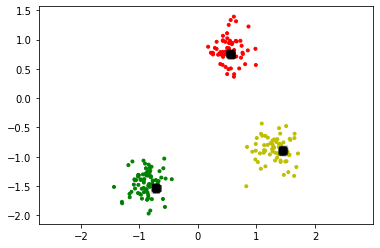

In [534]:
s2idx = (8,6)
simple_ds.Plot(idx=s2idx)
plt.plot(np.array(z[:,s2idx[0]]), np.array(z[:,s2idx[1]]), 's', color=[0,0,0,0.1]);

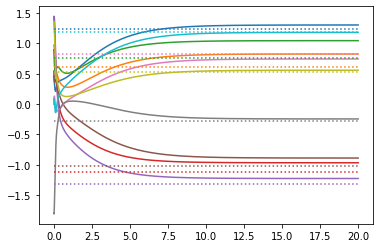

In [542]:
x_mean = simple_ds.ClassMean()
sampnum = 42
sampclass = torch.argmax(net.lyr[-1].x[sampnum])
colours = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'];
net.lyr[0].Plot(net.t_history, idx=sampnum)
for k,a in enumerate(x_mean[sampclass]):
    plt.plot([net.t_history[0],net.t_history[-1]], [a,a], ':', color=colours[k]);